In [1]:
# CELL 1: Required imports and data loading
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import nltk
import sklearn
import sklearn_crfsuite
from nltk.corpus import brown
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import re
import seaborn as sns
from collections import Counter

# Brown Corpus
nltk.download('brown')
nltk.download('universal_tagset')

# Universal tagset daala
brown_sents = brown.tagged_sents(tagset='universal')


[nltk_data] Downloading package brown to
[nltk_data]     /Users/thesakshipandey/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/thesakshipandey/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [10]:
# CELL 2: Feature extraction functions
from nltk.stem import SnowballStemmer
import re

# SnowballStemmer words ka stem (root) find karta hai, jaise [cooking] -> [cook]
stemmer = SnowballStemmer("english")

# Verb ke suffix ko check karne ke liye (jaise 'ing', 'ed', 'es', 's')
def is_verb_suffix(word):
    return word.lower().endswith(('ing', 'ed', 'es', 's'))

# Word ka shape detect karne ke liye 
def word_shape(word):
    if word.isdigit():
        return "numeric"  
    elif word.isupper():
        return "all_caps"  
    elif word.istitle():
        return "title_case"  
    elif word.islower():
        return "all_lower"  
    else:
        return "mixed_case"  # Agar word mixed case mein hai (jaise ButterFly), toh mixed_case

def contains_punctuation(word):
    return bool(re.search(r'[^\w\s]', word))

def is_gerund_in_context(sent, i):
    word = sent[i][0].lower()
    
    # gerund --> ends with 'ing'
    if word.endswith('ing') and i > 0:
        next_word = sent[i + 1][0].lower() if i < len(sent) - 1 else ''
        if next_word in ('is', 'are', 'was', 'were'):  # AUX
            return True
    return False

# ------ MAIN WORD2FEATURE FUNCTION ------
def word2features(sent, i):
    word = sent[i][0]  # Current word
    stem = stemmer.stem(word)  # Stem find karte hain word ka

    # Current word ke core features
    features = {
        'word': word,  
        'stem': stem,  
        'suffix[-4:]': word.lower()[-4:],  
        'suffix[-3:]': word.lower()[-3:],  
        'suffix[-2:]': word.lower()[-2:],  
        'suffix[-1:]': word.lower()[-1:],  
        'word.shape': word_shape(word),  
        'word.istitle()': word.istitle(),  
        'word.isupper()': word.isupper(),  
        'word.isdigit()': word.isdigit(),  
        'word_len': len(word),  
        'contains_hyphen': '-' in word,  
        'contains_digit': any(char.isdigit() for char in word),  
        'contains_punctuation': contains_punctuation(word),  
        'verb_suffix': is_verb_suffix(word),
        'likely_gerund': is_gerund_in_context(sent, i),
    }

    if len(word) < 3:
        features['word_len_short'] = True  
    elif len(word) <= 6:
        features['word_len_medium'] = True  
    else:
        features['word_len_long'] = True  

    # Previous word ke features 
    if i > 0:
        prev_word = sent[i - 1][0]
        features.update({
            'prev_word': prev_word,  # Previous word
            'prev_word.istitle()': prev_word.istitle(),  
            'prev_word.isupper()': prev_word.isupper(),  
            'prev_word.shape': word_shape(prev_word),  
            'prev_word_len': len(prev_word), 
        })
    else:
        features['BOS'] = True  # Agar pehla word hai toh "Beginning of Sent" 

    # Second previous word ke features 
    if i > 1:
        prev2_word = sent[i - 2][0]
        features.update({
            'prev2_word': prev2_word,  # Second previous word
            'prev2_word.shape': word_shape(prev2_word),  
        })

    # Next word ke features 
    if i < len(sent) - 1:
        next_word = sent[i + 1][0]
        features.update({
            'next_word': next_word,  # Next word
            'next_word.istitle()': next_word.istitle(),  
            'next_word.isupper()': next_word.isupper(),  
            'next_word.shape': word_shape(next_word),  
            'next_word_len': len(next_word),  
        })
    else:
        features['EOS'] = True  # Agar last word hai toh "End of Sent" 

    # Second next word ke features 
    if i < len(sent) - 2:
        next2_word = sent[i + 2][0]
        features.update({
            'next2_word': next2_word,  # Second next word
            'next2_word.shape': word_shape(next2_word), 
        })

    return features


In [11]:
# CELL 3: CRF Beam Search class with forward and backward vectors
class CRF_BeamSearch_FwdBwd:
    def __init__(self, model, beam_size=3):
        self.model = model
        self.beam_size = beam_size

    def predict(self, X_test):
        all_predictions = []
        all_forward_vectors = []
        all_backward_vectors = []

        for sequence in X_test:
            scores = self.model.predict_marginals_single(sequence)

            forward_vector = np.zeros(len(scores))
            backward_vector = np.zeros(len(scores))

            first_word_scores = scores[0]
            beam = [(prob, [tag]) for tag, prob in first_word_scores.items()]
            beam = sorted(beam, key=lambda x: x[0], reverse=True)[:self.beam_size]

            forward_vector[0] = max(first_word_scores.values())

            for t in range(1, len(sequence)):
                new_beam = []
                current_scores = scores[t]

                for score, tags_sequence in beam:
                    for tag, tag_score in current_scores.items():
                        new_sequence = tags_sequence + [tag]
                        new_score = score * tag_score
                        new_beam.append((new_score, new_sequence))

                beam = sorted(new_beam, key=lambda x: x[0], reverse=True)[:self.beam_size]
                forward_vector[t] = max(current_scores.values())

            best_sequence = max(beam, key=lambda x: x[0])[1]
            all_predictions.append(best_sequence)

            for t in reversed(range(len(sequence))):
                current_scores = scores[t]
                backward_vector[t] = max(current_scores.values())

            all_forward_vectors.append(forward_vector)
            all_backward_vectors.append(backward_vector)

        return all_predictions, all_forward_vectors, all_backward_vectors


In [12]:
# CELL 4: Feature extraction and K-Fold cross-validation
def get_features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def get_tags(sent):
    return [tag for _, tag in sent]

sentences = brown_sents 
X = [get_features(s) for s in sentences]  
y = [get_tags(s) for s in sentences]  

kf = KFold(n_splits=5, shuffle=True, random_state=42)  

fold = 1
accuracies = []  
all_y_true = []  
all_y_pred = []  

for train_index, test_index in kf.split(X):
    X_train = [X[i] for i in train_index]  
    y_train = [y[i] for i in train_index]  
    X_test = [X[i] for i in test_index]  
    y_test = [y[i] for i in test_index]  

    # CRF Model train 
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1,  
        c2=0.1,  
        max_iterations=50
    )
    crf.fit(X_train, y_train)

    # pred using Beam Search with forward and backward vectors
    beam_search = CRF_BeamSearch_FwdBwd(crf, beam_size=7)  
    y_pred, _, _ = beam_search.predict(X_test)  

    y_test_flat = [tag for sent in y_test for tag in sent]
    y_pred_flat = [tag for sent in y_pred for tag in sent]

    all_y_true.extend(y_test_flat)  
    all_y_pred.extend(y_pred_flat)

    accuracy = accuracy_score(y_test_flat, y_pred_flat)
    accuracies.append(accuracy) 

    print(f"Fold {fold}: Accuracy = {accuracy}") 
    fold += 1

mean_accuracy = sum(accuracies) / len(accuracies)  
print(f"\nMean Accuracy across 5 folds: {mean_accuracy}")  


Fold 1: Accuracy = 0.9793340145821746
Fold 2: Accuracy = 0.97875924705193
Fold 3: Accuracy = 0.978777515450316
Fold 4: Accuracy = 0.9787966015337517
Fold 5: Accuracy = 0.9791198363663202

Mean Accuracy across 5 folds: 0.9789574429968985



Classification Report (CRF):
              precision    recall  f1-score   support

         DET       0.99      0.99      0.99    137019
         ADJ       0.94      0.94      0.94     83721
         NUM       0.98      0.98      0.98     14874
        VERB       0.98      0.98      0.98    182750
         ADV       0.95      0.93      0.94     56239
        CONJ       0.99      1.00      1.00     38151
        PRON       0.99      0.99      0.99     49334
         PRT       0.95      0.94      0.95     29829
         ADP       0.98      0.99      0.98    144766
        NOUN       0.98      0.98      0.98    275558
           X       0.79      0.45      0.58      1386
           .       1.00      1.00      1.00    147565

    accuracy                           0.98   1161192
   macro avg       0.96      0.93      0.94   1161192
weighted avg       0.98      0.98      0.98   1161192



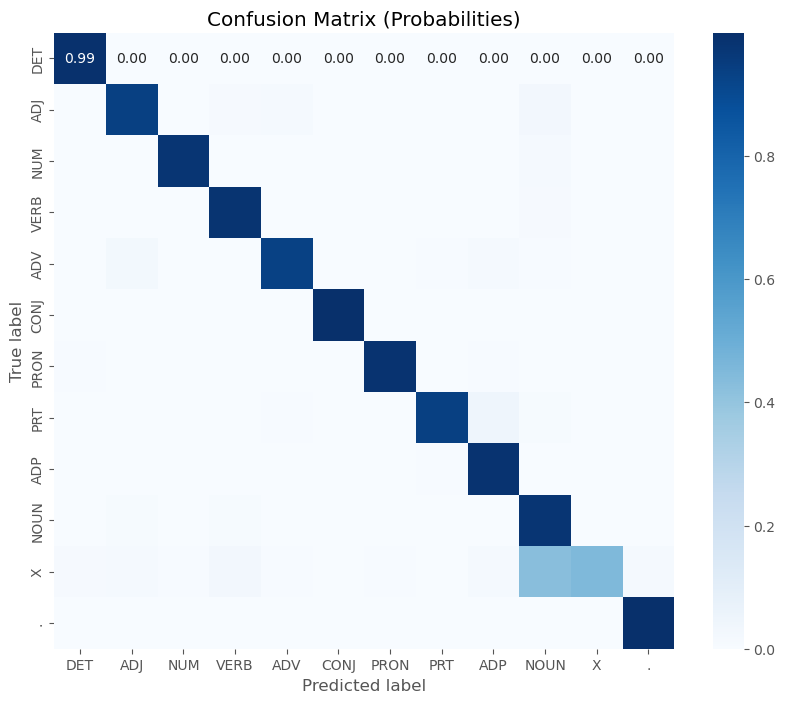


Per-POS Accuracy:
DET: 0.99
ADJ: 0.94
NUM: 0.98
VERB: 0.98
ADV: 0.93
CONJ: 1.00
PRON: 0.99
PRT: 0.94
ADP: 0.99
NOUN: 0.98
X: 0.45
.: 1.00


In [13]:
# CELL 5: Plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    
    cm_normalized = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')  
    cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaNs with 0s

    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix (Probabilities)')
    plt.show()

# Per-POS accuracy
def per_pos_accuracy(y_true, y_pred, pos_tags):
    correct = Counter()
    total = Counter()

    for true_tag, pred_tag in zip(y_true, y_pred):
        total[true_tag] += 1
        if true_tag == pred_tag:
            correct[true_tag] += 1

    pos_accuracy = {tag: correct[tag] / total[tag] for tag in pos_tags}
    return pos_accuracy

# Report precision, recall, and F1 score
labels = list(set(tag for sent in y for tag in sent))  
print("\nClassification Report (CRF):")
print(classification_report(all_y_true, all_y_pred, labels=labels))

# Plot confusion matrix
plot_confusion_matrix(all_y_true, all_y_pred, labels)

# Report per-POS accuracy
pos_accuracy = per_pos_accuracy(all_y_true, all_y_pred, labels)
print("\nPer-POS Accuracy:")
for pos, acc in pos_accuracy.items():
    print(f"{pos}: {acc:.2f}")


In [14]:
# CELL 6: Tokenization and POS tagging with vectors
import re
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Tokenize a sentence
def tokenize_sentence(sentence):
    # Initial tokenization
    tokens = tokens = re.findall(r"\(\w\)|\d+%|\d+/\w+|\w+['’]?\w*|[^\w\s]", sentence)
    
    return tokens

def pos_tag_sentence_with_fwd_bwd(sentence, model, beam_size=5):
    tokens = tokenize_sentence(sentence)

    sentence_with_dummy_tags = [(token, 'X') for token in tokens]
    features = [word2features(sentence_with_dummy_tags, i) for i in range(len(tokens))]

    beam_search = CRF_BeamSearch_FwdBwd(model, beam_size=beam_size)
    predicted_tags, forward_vectors, backward_vectors = beam_search.predict([features])

    return list(zip(tokens, predicted_tags[0])), forward_vectors[0], backward_vectors[0]


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thesakshipandey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
# CELL 7: Gradio interface for tagging
import gradio as gr

def gradio_pos_tagger(sentence):
    tagged_sentence, forward_vector, backward_vector = pos_tag_sentence_with_fwd_bwd(sentence, crf)
    return tagged_sentence, forward_vector, backward_vector

with gr.Blocks(css="""
textarea {
    font-size: 24px !important;
    font-weight: bold !important;
    padding: 20px !important;
    height: 150px !important;  /* Make input box larger */
    line-height: 1.6 !important;
}

.output_textbox {
    font-size: 28px !important;
    font-weight: bold !important;
    padding: 30px !important;
    line-height: 1.8 !important;
    white-space: pre-wrap !important;  /* Preserve line breaks */
}
""") as demo:
    gr.Markdown("# CRF POS Tagger")
    gr.Markdown("Enter a sentence and see the predicted Part-of-Speech (POS) tags using a CRF model, along with forward and backward vectors.")

    sentence_input = gr.Textbox(lines=5, placeholder="Type your sentence here...")
    output_display = gr.Textbox(label="Tagged sentence with vectors", elem_id="output_textbox")

    def update_output(sentence):
        tagged_sentence, forward_vector, backward_vector = gradio_pos_tagger(sentence)

        formatted_sentence = ""
        for i, (word, tag) in enumerate(tagged_sentence):
            formatted_sentence += f"{word}    ====>    {tag}\n"
            formatted_sentence += f"Forward Vector: {forward_vector[i]:.4f}, Backward Vector: {backward_vector[i]:.4f}\n"
            formatted_sentence += "----------------------------------------------------\n"
        
        for i, (word, tag) in enumerate(tagged_sentence):
            formatted_sentence += f"{word}    ====>    {tag}\n"

        return gr.update(value=formatted_sentence)

    sentence_input.submit(update_output, inputs=sentence_input, outputs=output_display)

    # examples
    gr.Examples(
        examples=[
            ["The quick brown fox jumps over the lazy dog."],
            ["Painting is a relaxing hobby."],
            ["¡Hola! ¿Cómo estás?"]
        ],
        inputs=sentence_input
    )

demo.launch()


Running on local URL:  http://127.0.0.1:7879

To create a public link, set `share=True` in `launch()`.


In [29]:
# Example:
# sentence = "The quick brown fox jumps over the lazy dog."
# sentence = "She's been working hard, but he hasn't finished his part yet."
# sentence = "The teacher said, 'It's important to finish the assignment by Friday.'"
# sentence = "The company reported a revenue increase of 12% in Q4 2023."
# sentence = "Sakshi and Amit are friends."
# sentence = "Coloring is my hobby."
# sentence = "I like to eat (a) Apple, (b) Mango and (c) Banana."
# sentence = "India won the 2nd world cup in 2011."
# sentence = "Foxes foxes fox fox foxes."
# sentence = "Delhi is beautiful city and so is Mumbai"
# sentence = "The old mans the boats."
# sentence = "The cotton clothing is made of grows in Mississippi."
# sentence = "He doesn't know."
# sentence = "Buffalo buffaloes Buffalo buffaloes buffalo buffalo Buffalo buffaloes."
# sentence = "Below decks, Seaman 1/c Stanley Bishop had begun to write a letter home."
# sentence = "Mr. Abhishek."
# sentence = "Cycling is a fun activity, a convenient mode of transport, and a good form of exercise."
# sentence = "we are going to the bank."
# sentence = "The project manager decided to lead the task."
# sentence = "He decided to desert his dessert in the desert."
# sentence = "¡Hola! ¿Cómo estás?"
# sentence = "My name is Sakshi, what is your name?"
# sentence = "Swimming in the ocean is refreshing during the summers."
# sentence = "I had a very refreshing morning."
# sentence = "A refreshing breeze came through the open window."
# sentence = "Painting is a relaxing hobby."
# sentence = "Dancing is a great way to relieve stress."
# sentence = "Writing essays helps improve critical thinking skills."
# sentence = "The United Kingdom and the USA are on the 2 sides of Atlantic."
# sentence = "The UK and the USA are on the 2 sides of Atlantic."
# sentence = "she saw her duck by the lake."
# sentence = "I will bank on reaching the bank before sunset."



tagged_sentence = pos_tag_sentence_with_fwd_bwd(sentence, crf)
print("Tagged Sentence:", tagged_sentence)


Tagged Sentence: ([('I', 'PRON'), ('will', 'VERB'), ('bank', 'VERB'), ('on', 'ADP'), ('reaching', 'VERB'), ('the', 'DET'), ('bank', 'NOUN'), ('before', 'ADP'), ('sunset', 'NOUN'), ('.', '.')], array([0.99968275, 0.9997341 , 0.96150385, 0.6397828 , 0.99616216,
       0.99999426, 0.99758308, 0.97507804, 0.9932495 , 0.99999506]), array([0.99968275, 0.9997341 , 0.96150385, 0.6397828 , 0.99616216,
       0.99999426, 0.99758308, 0.97507804, 0.9932495 , 0.99999506]))
